In [1]:
import gym
import random
import numpy as np
import tensorflow as tf

from collections import deque

from matplotlib import pyplot as plt

seed = 0
np.random.seed(seed)
random.seed(seed)

# Helper Function for Visualization

In [14]:
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    display(display_animation(anim, default_mode='loop'))

# Softmax and Sparsemax Distribution

In [2]:
def softmax(x, scale = 1):
    x = np.array(x)/scale
    max_x = np.max(x)
    e_x = np.exp(x - max_x)
    p = e_x/e_x.sum()
    p = p/p.sum()

    return p

def logsumexp(x, scale = 1):
    x = np.array(x)/scale
    max_x = np.max(x)
    lse_x = max_x + np.log(np.exp(x-max_x).sum())
    lse_x = scale*lse_x
    return lse_x

def sparsedist(z, scale=1.):
    z = np.array(z/scale)
    if len(z.shape) == 1:
        z = np.reshape(z,(1,-1))
    z = z - np.mean(z, axis=1)[:, np.newaxis]

    # sort z
    z_sorted = np.sort(z, axis=1)[:, ::-1]

    # calculate k(z)
    z_cumsum = np.cumsum(z_sorted, axis=1)
    k = np.arange(1, z.shape[1] + 1)
    z_check = 1 + k * z_sorted > z_cumsum
    k_z = z.shape[1] - np.argmax(z_check[:, ::-1], axis=1)

    # calculate tau(z)
    tau_sum = z_cumsum[np.arange(0, z.shape[0]), k_z - 1]
    tau_z = ((tau_sum - 1) / k_z).reshape(-1, 1)

    # calculate p
    p = np.maximum(0, z - tau_z)
    return p 

def sparsemax(z, scale=1.):
    z = np.array(z/scale)    
    z = z - np.mean(z, axis=1)[:, np.newaxis]

    # calculate sum over S(z)
    p = sparsedist(z)
    s = p > 0
    # z_i^2 - tau(z)^2 = p_i (2 * z_i - p_i) for i \in S(z)
    S_sum = np.sum(s * p * (2 * z - p), axis=1)

    return 0.5 * S_sum + 0.5

# Pioritized Replay Memory

In [3]:
class PrioritizedReplayMemory: #PER memory
    def __init__(self, memory_size=10000, per_alpha=0.2, per_beta0=0.4):       
        self.memory = SumTree(capacity=memory_size) # Use sumtree
        self.memory_size = memory_size
       
        # hyperparameter for importance probability
        self.per_alpha = per_alpha
        
        # hyperparameter for importance weight
        self.per_beta0 = per_beta0
        self.per_beta = per_beta0
        
        self.per_epsilon = 1E-6
        self.prio_max = 0
    
    def anneal_per_importance_sampling(self, step, max_step): # Anneal beta
        self.per_beta = self.per_beta0 + step*(1-self.per_beta0)/max_step

    def error2priority(self, errors): # Get priority from TD error
        return np.power(np.abs(errors) + self.per_epsilon, self.per_alpha)

    def save_experience(self, state, action, reward, state_next, done):
        experience = (state, action, reward, state_next, done)
        self.memory.add(np.max([self.prio_max, self.per_epsilon]), experience) # Add experience with importance weight
        
    def retrieve_experience(self, batch_size):
        idx = None
        priorities = None
        w = None

        idx, priorities, experience = self.memory.sample(batch_size) # Sample batch from memory
        sampling_probabilities = priorities / self.memory.total() # Make priorities to be sum to one
        w = np.power(self.memory.n_entries * sampling_probabilities, -self.per_beta) # Importance weight
        w = w / w.max()
        return idx, priorities, w, experience
    
    def update_experience_weight(self, idx, errors ):
        priorities = self.error2priority(errors)
        for i in range(len(idx)):
            self.memory.update(idx[i], priorities[i])
        self.prio_max = max(priorities.max(), self.prio_max)
        
class SumTree: # Sum Tree Memory
    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.tree = np.zeros(2*capacity - 1)
        self.data = np.zeros(capacity, dtype=object)

        self.write = 0
        self.n_entries = 0

        self.tree_len = len(self.tree)

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1

        if left >= self.tree_len:
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            right = left + 1
            return self._retrieve(right, s-self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        data_idx = idx - self.capacity + 1

        return idx, self.tree[idx], self.data[data_idx]

    def sample(self, batch_size):
        batch_idx = [None] * batch_size
        batch_priorities = [None] * batch_size
        batch = [None] * batch_size
        segment = self.total() / batch_size

        a = [segment*i for i in range(batch_size)]
        b = [segment * (i+1) for i in range(batch_size)]
        s = np.random.uniform(a, b)

        for i in range(batch_size):
            (batch_idx[i], batch_priorities[i], batch[i]) = self.get(s[i])

        return batch_idx, batch_priorities, batch

# DQN Agent

In [4]:
class DQNAgent:
    def __init__(self, obs_dim, n_action, seed=0,
                 discount_factor = 0.995, epsilon_decay = 0.995, epsilon_min = 0.01, scale=1.0, keep_rate=0.7,
                 learning_rate = 1e-4, # Step size for Adam
                 batch_size = 64, 
                 memory_size = 5000, hidden_unit_size = 128, strategy="Epsilon"):
        
        self.seed = seed
        
        # Environment Information
        self.obs_dim = obs_dim
        self.n_action = n_action
        self.discount_factor = discount_factor
        
        # Epsilon Greedy Policy
        self.strategy = strategy
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.scale = scale
        self.keep_rate = keep_rate
        
        # Network Hyperparameters
        self.hidden_unit_size = hidden_unit_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.train_start = 1000

        # Experience Replay
        self.memory = PrioritizedReplayMemory(memory_size=memory_size)
        
        # Define Computational Graph in TF
        self.g = tf.Graph()
        with self.g.as_default():
            self.build_placeholders()
            self.build_model()
            self.build_loss()
            self.build_update_operation()
            self.init_session() # Initialize all parameters in graph
    
    def build_placeholders(self): # Build input and output place holder
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs') # Input state
        self.target_ph = tf.placeholder(tf.float32, (None, self.n_action), 'target') # TD target
        self.batch_weights_ph = tf.placeholder(tf.float32,(None, self.n_action), name="batch_weights")
        self.learning_rate_ph = tf.placeholder(tf.float32, (), 'lr')        
        self.keep_rate_ph = tf.placeholder(tf.float32, (), 'rate')        
    
    def build_model(self): # Build networks
        hid1_size = self.hidden_unit_size
        hid2_size = self.hidden_unit_size
        
        with tf.variable_scope('q_prediction'): # Prediction Network / Two layered perceptron / Training Parameters
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden1')
            out = tf.layers.dropout(out,rate=self.keep_rate_ph,seed=self.seed,name='hidden1_dropout')
            out = tf.layers.dense(out, hid2_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden2')
            out = tf.layers.dropout(out,rate=self.keep_rate_ph,seed=self.seed,name='hidden2_dropout')
            self.q_predict = tf.layers.dense(out, self.n_action, # Linear Layer
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='q_predict')
                        
        with tf.variable_scope('q_target'): # Target Network / Two layered perceptron / Old Parameters
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden1')
            out = tf.layers.dropout(out,rate=self.keep_rate_ph,seed=self.seed,name='hidden1_dropout')
            out = tf.layers.dense(out, hid2_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden2')
            out = tf.layers.dropout(out,rate=self.keep_rate_ph,seed=self.seed,name='hidden2_dropout')
            self.q_predict_old = tf.layers.dense(out, self.n_action, # Linear Layer
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='q_predict')
        
        self.weights = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_prediction') # Get Prediction network's Parameters
        self.weights_old = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_target') # Get Target network's Parameters

    def build_loss(self):
        self.errors = self.target_ph - self.q_predict
        self.loss = 0.5*tf.reduce_mean(self.batch_weights_ph*tf.square(self.target_ph - self.q_predict))
        self.optim = tf.train.AdamOptimizer(learning_rate=self.learning_rate_ph).minimize(self.loss)
        
    def build_update_operation(self): # Define parameter update operation in TF graph
        update_ops = [] 
        for var, var_old in zip(self.weights, self.weights_old): # Update Target Network's Parameter with Prediction Network
            update_ops.append(var_old.assign(var))
        self.update_ops = update_ops
        
    def init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g) # Initialize session
        self.sess.run(tf.global_variables_initializer())
        self.sess.run(self.update_ops)
        
    def update_target(self): # Update parameters
        self.sess.run(self.update_ops)
        
    def update_policy(self):
        if self.epsilon > self.epsilon_min: # Update epsilon
            self.epsilon *= self.epsilon_decay
        
    def update_memory(self, step, max_step):
        self.memory.anneal_per_importance_sampling(step,max_step)
        
    def get_prediction_old(self, obs, keep_rate=1.0): # Get Q value from target network
        q_value_old = self.sess.run(self.q_predict_old,feed_dict={self.obs_ph:obs,self.keep_rate_ph:keep_rate})        
        return q_value_old
        
    def get_prediction(self, obs, keep_rate=1.0): # Get Q value from prediction network
        q_value = self.sess.run(self.q_predict,feed_dict={self.obs_ph:obs,self.keep_rate_ph:keep_rate})        
        return q_value
    
    def get_action(self, obs): # Epsilon Greedy policy
        
        if self.strategy == "Random":
            policy = np.ones(self.n_action) / self.n_action
        elif self.strategy == "Epsilon":
            q_value = self.get_prediction([obs],keep_rate=1.0)
            a_max = np.argmax(q_value)
            policy = np.ones(self.n_action) * self.epsilon / self.n_action
            policy[a_max] += 1. - self.epsilon
        elif self.strategy == "Softmax":
            q_value = self.get_prediction([obs],keep_rate=1.0)
            softmax_policy = softmax(q_value, scale=self.scale)
            policy = softmax_policy[0]
        elif self.strategy == "Sparsemax":
            q_value = self.get_prediction([obs],keep_rate=1.0)
            sparsemax_policy = sparsedist(q_value, scale=self.scale)
            sparsemax_policy = np.reshape(sparsemax_policy,(-1,))
            policy = np.ones(self.n_action) * self.epsilon / self.n_action + sparsemax_policy * (1. - self.epsilon)
        elif self.strategy == "Thompson":
            q_value = self.get_prediction([obs],keep_rate=self.keep_rate)
            a_max = np.argmax(q_value)
            policy = np.zeros(self.n_action)
            policy[a_max] = 1.
            
        policy = policy/np.sum(policy)
        action = np.random.choice(self.n_action, p=policy)
        
        return action

    def add_experience(self, obs, action, reward, next_obs, done): # Add experience to memory
        self.memory.save_experience(obs, action, reward, next_obs, done)

    def train_model(self):
        keep_rate=self.keep_rate
        if self.strategy is not "Thompson":
            keep_rate=1.0
        loss = np.nan
        n_entries = self.memory.memory.n_entries
            
        if n_entries > self.train_start: # Start training when the number of experience is greater than batch size
            
            # Randomly sample batch
            idx, priorities, w, mini_batch = self.memory.retrieve_experience(self.batch_size)
            batch_weights = np.transpose(np.tile(w, (self.n_action, 1)))
            
            observations = np.zeros((self.batch_size, self.obs_dim))
            next_observations = np.zeros((self.batch_size, self.obs_dim))
            actions, rewards, dones = [], [], []

            for i in range(self.batch_size):
                observations[i] = mini_batch[i][0]
                actions.append(mini_batch[i][1])
                rewards.append(mini_batch[i][2])
                next_observations[i] = mini_batch[i][3]
                dones.append(mini_batch[i][4])

            target = self.get_prediction(observations)
            next_q_value = self.get_prediction_old(next_observations)

            # BELLMAN UPDATE RULE 
            for i in range(self.batch_size):
                if dones[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(next_q_value[i]))

            loss, errors, _ = self.sess.run([self.loss, self.errors, self.optim], 
                                 feed_dict={self.obs_ph:observations,self.target_ph:target,self.batch_weights_ph:batch_weights,self.learning_rate_ph:self.learning_rate,self.keep_rate_ph:keep_rate})                        
            errors = errors[np.arange(len(errors)), actions]
            self.memory.update_experience_weight(idx, errors)
            
        return loss

# Define Environment

In [5]:
env = gym.make('Acrobot-v1')
obs_space = env.observation_space
print('Observation space')
print(type(obs_space))
print(obs_space.shape)
print("Dimension:{}".format(obs_space.shape[0]))
print("High: {}".format(obs_space.high))
print("Low: {}".format(obs_space.low))
print()

act_space = env.action_space
print('Action space')
print(type(act_space))
print("Total {} actions".format(act_space.n))
print()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Observation space
<class 'gym.spaces.box.Box'>
(6,)
Dimension:6
High: [ 1.        1.        1.        1.       12.566371 28.274334]
Low: [ -1.        -1.        -1.        -1.       -12.566371 -28.274334]

Action space
<class 'gym.spaces.discrete.Discrete'>
Total 3 actions



# Experiments

In [6]:
def experiments(strategy="Epsilon"):
    env.seed(seed)
    max_t = env.spec.max_episode_steps
    agent = DQNAgent(env.observation_space.high.shape[0],env.action_space.n,strategy=strategy)

    avg_return_list = []
    avg_return = deque(maxlen=10)
    avg_loss = deque(maxlen=10)
    nepisodes = 500
    for i in range(nepisodes+1):
        obs = env.reset()
        done = False
        total_reward = 0
        total_loss = 0
        for t in range(max_t):
            # Get transition
            action = agent.get_action(obs)
            next_obs, reward, done, info = env.step(action)

            # Add experience
            agent.add_experience(obs,action,reward,next_obs,done)

            # Online update perdiction network parameter
            loss = agent.train_model()

            obs = next_obs
            total_reward += reward
            total_loss += loss

            if done:
                break

            # Update target network parameter
            agent.update_target()
        agent.update_policy()

        avg_return.append(total_reward)
        avg_loss.append(total_loss)
        avg_return_list.append(np.mean(avg_return))

        if (np.mean(avg_return) > -110): # Threshold return to success cartpole

            print('[{}/{}] loss : {:.3f}, return : {:.3f}'.format(i,nepisodes, np.mean(avg_loss), np.mean(avg_return)))
            print('The problem is solved with {} episodes'.format(i))
            break

        if (i%100)==0:
            print('[{}/{}] loss : {:.3f}, return : {:.3f}'.format(i,nepisodes, np.mean(avg_loss), np.mean(avg_return)))
    return avg_return_list, agent

avg_return_list_epsilon, epsilon_agent=experiments(strategy="Epsilon")

[0/500] loss : nan, return : -500.000
[100/500] loss : 2136.587, return : -378.600
[200/500] loss : 165.889, return : -117.100
[256/500] loss : 134.398, return : -109.900
The problem is solved with 256 episodes


In [8]:
avg_return_list_thompson, thompson_agent=experiments(strategy="Thompson")
avg_return_list_softmax, softmax_agent=experiments(strategy="Softmax")
avg_return_list_sparsemax, sparsemax_agent=experiments(strategy="Sparsemax")

[0/500] loss : nan, return : -500.000
[100/500] loss : 4164.412, return : -500.000
[200/500] loss : 785.574, return : -222.900
[218/500] loss : 372.308, return : -109.200
The problem is solved with 218 episodes
[0/500] loss : nan, return : -500.000
[100/500] loss : 3409.700, return : -499.500
[200/500] loss : 290.289, return : -179.800
[300/500] loss : 171.009, return : -145.900
[400/500] loss : 123.900, return : -165.200
[500/500] loss : 106.155, return : -136.500
[0/500] loss : nan, return : -500.000
[100/500] loss : 3260.265, return : -500.000
[200/500] loss : 249.853, return : -161.800
[300/500] loss : 142.605, return : -119.600
[308/500] loss : 115.737, return : -104.100
The problem is solved with 308 episodes


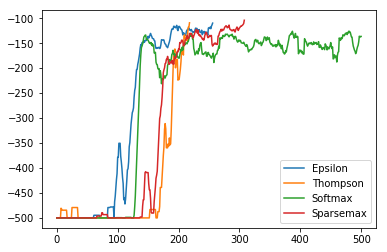

In [10]:
plt.plot(avg_return_list_epsilon,label="Epsilon")
plt.plot(avg_return_list_thompson,label="Thompson")
plt.plot(avg_return_list_softmax,label="Softmax")
plt.plot(avg_return_list_sparsemax,label="Sparsemax")
plt.legend()
plt.show()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Total Reward : -119.00



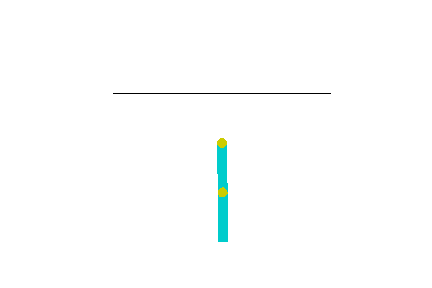
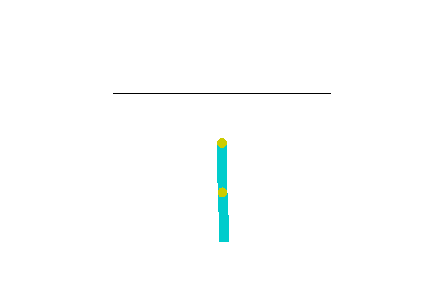
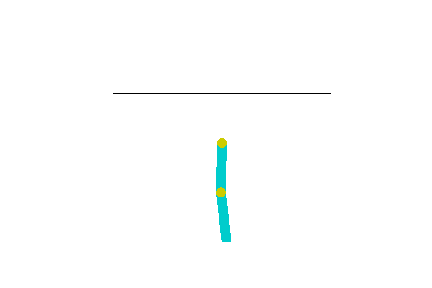
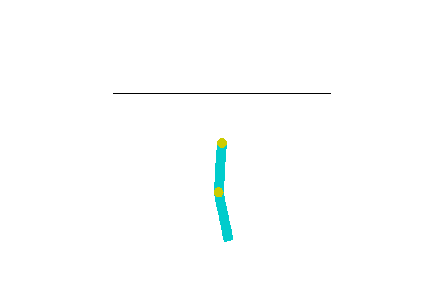
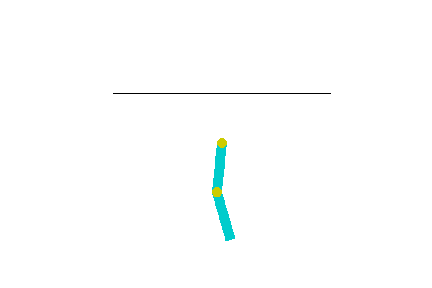
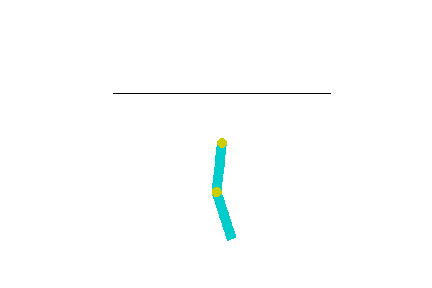
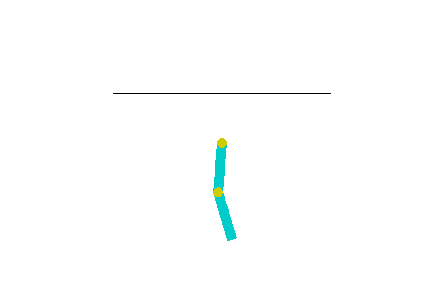
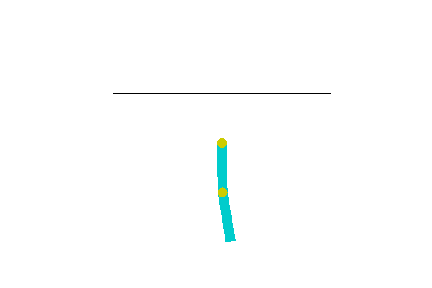
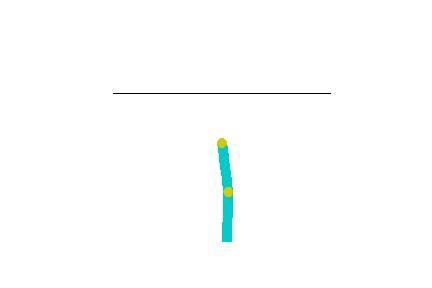
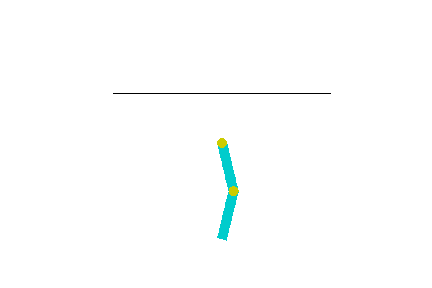
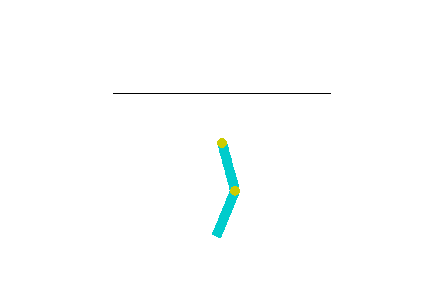
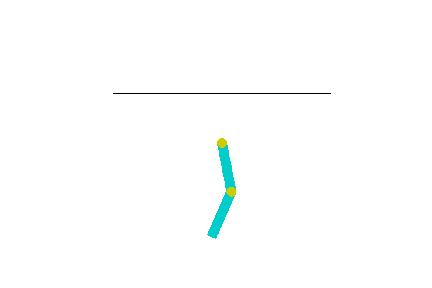
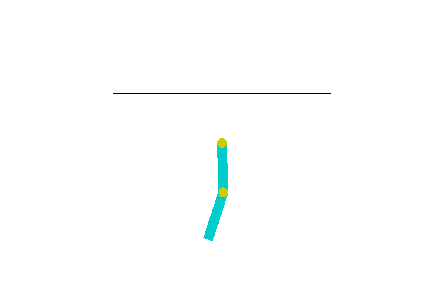
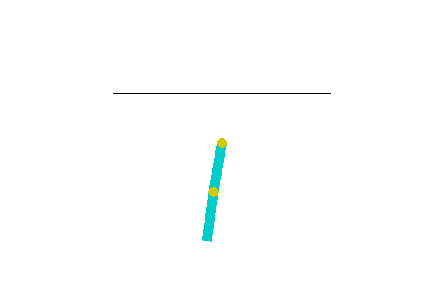
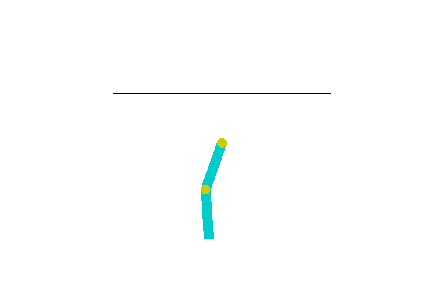
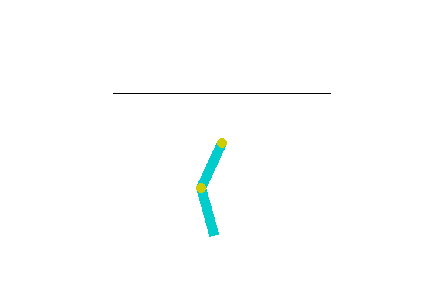
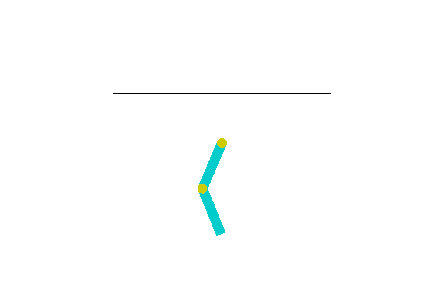
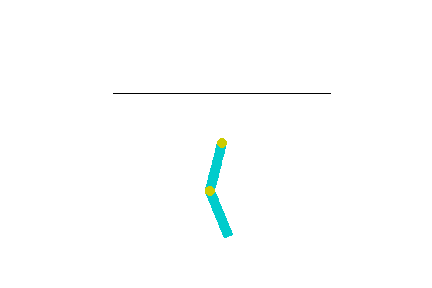
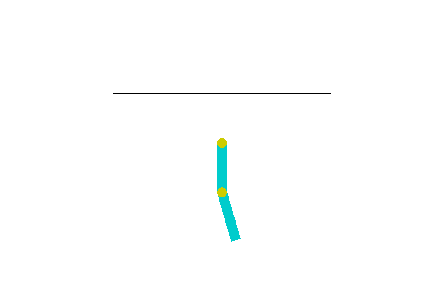
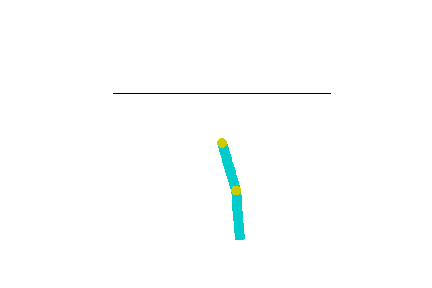
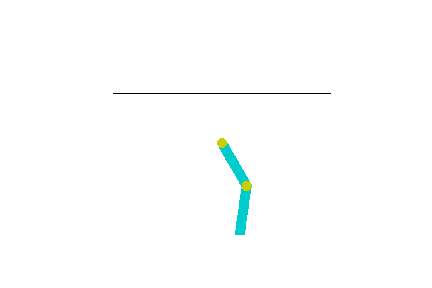
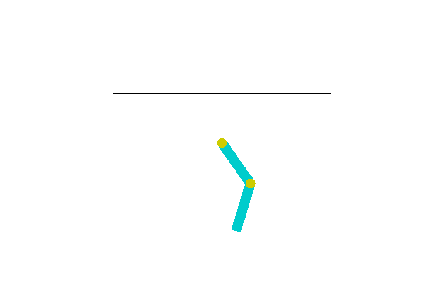
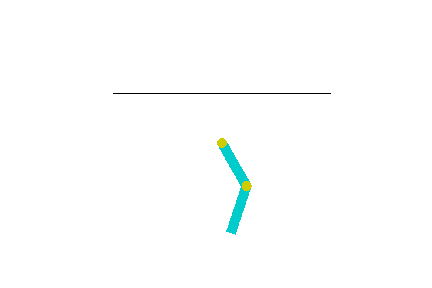
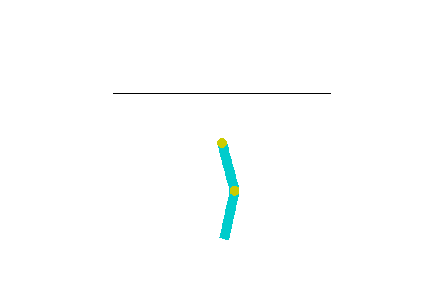
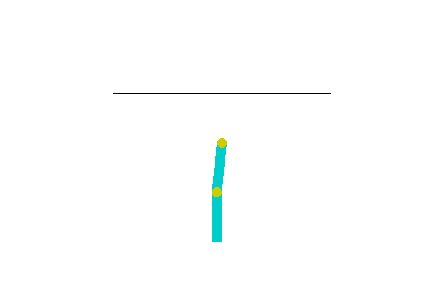
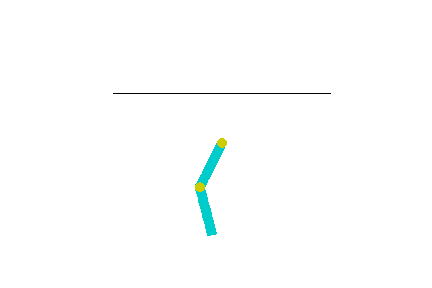
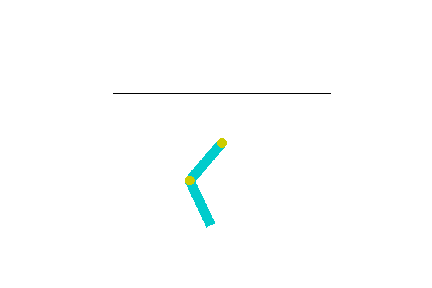
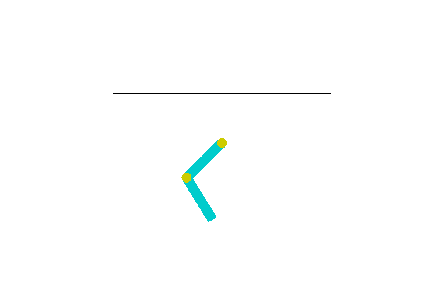
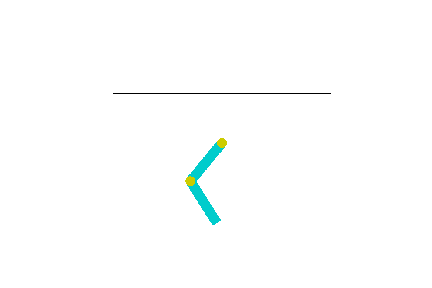
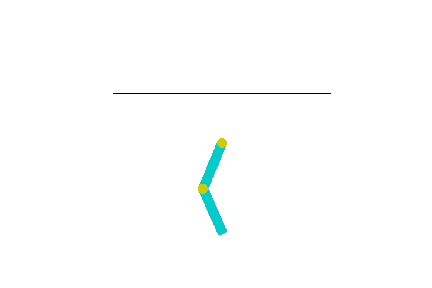
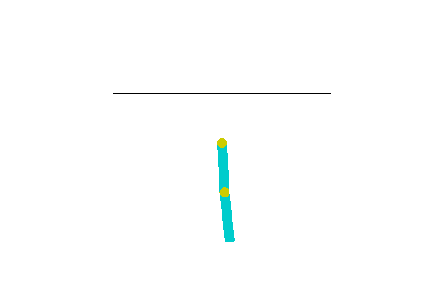
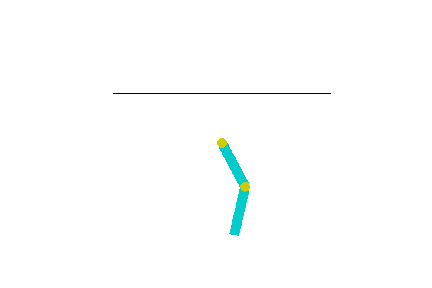
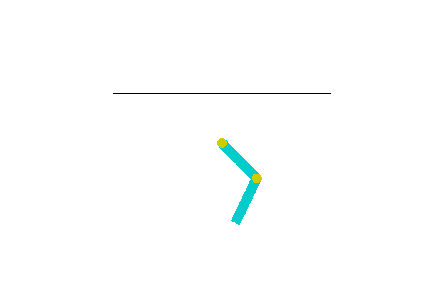
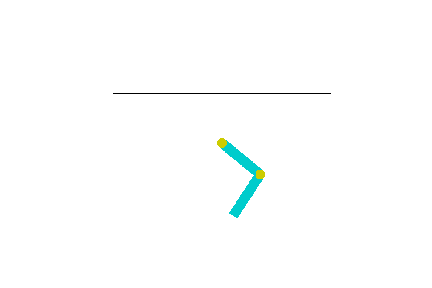
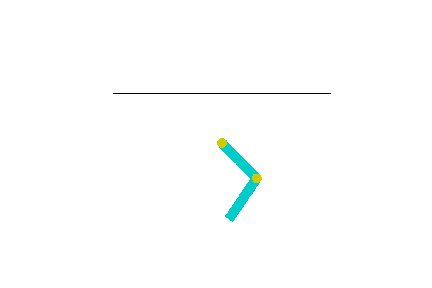
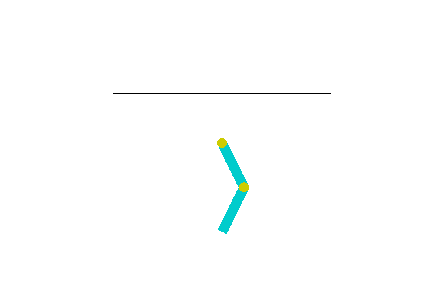
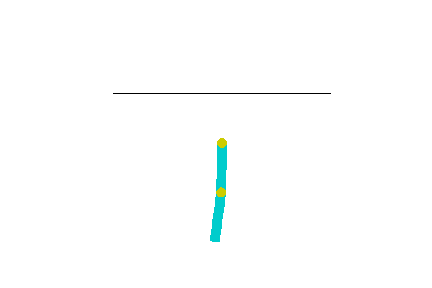
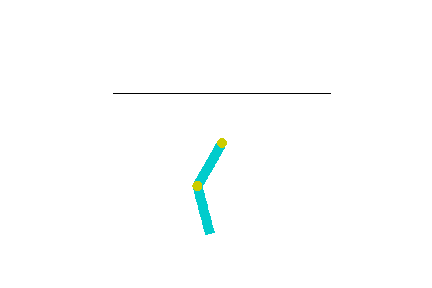
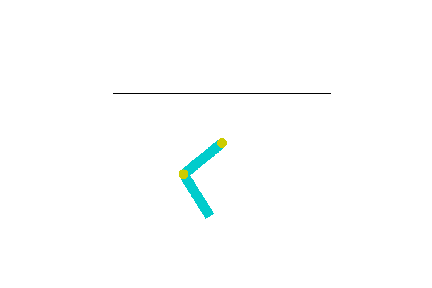
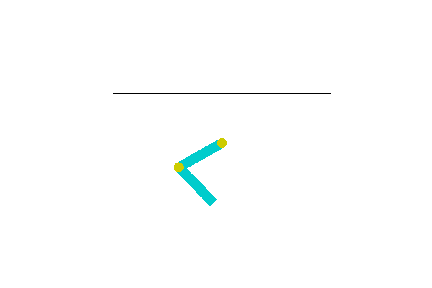
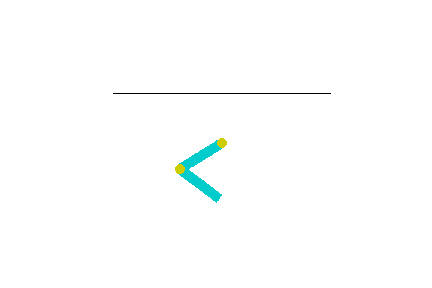
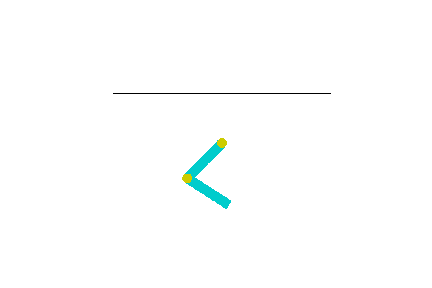
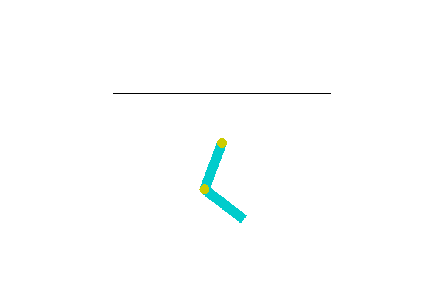
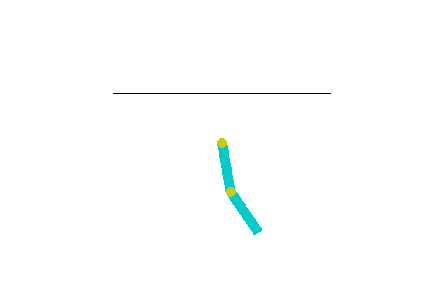
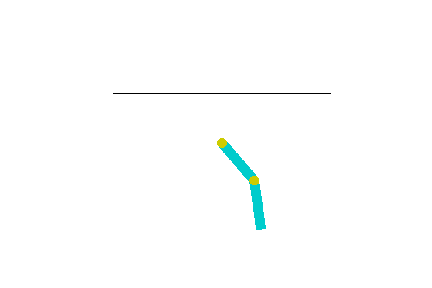
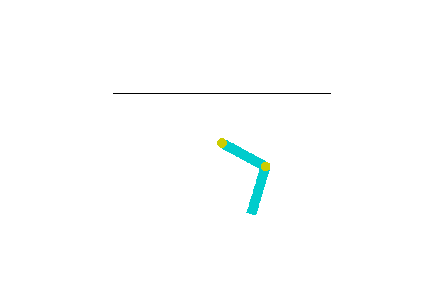
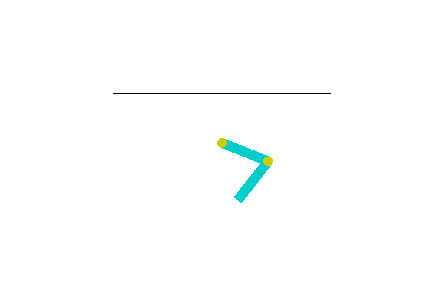
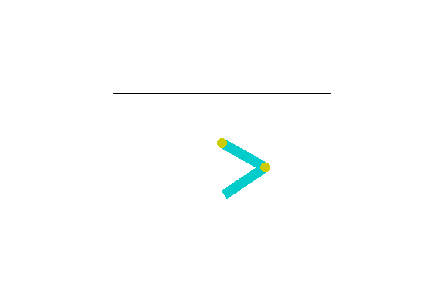
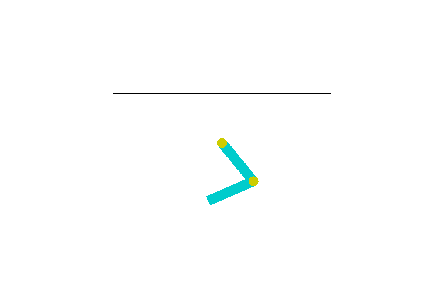
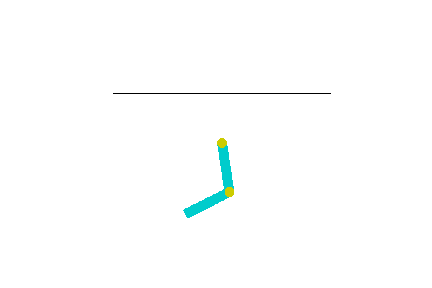
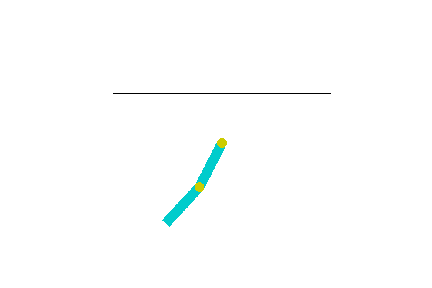
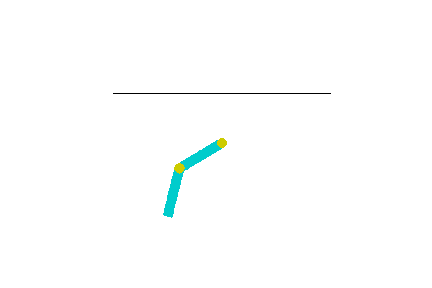
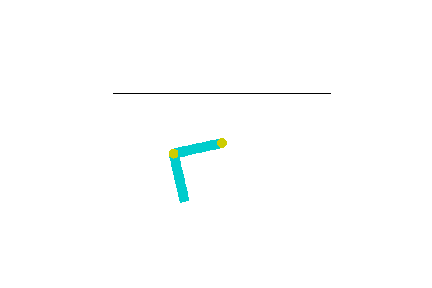
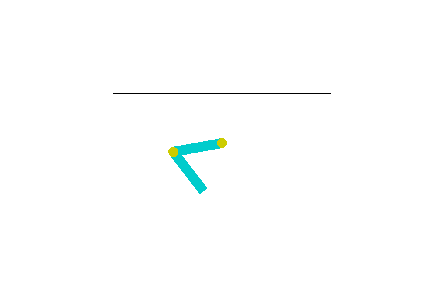
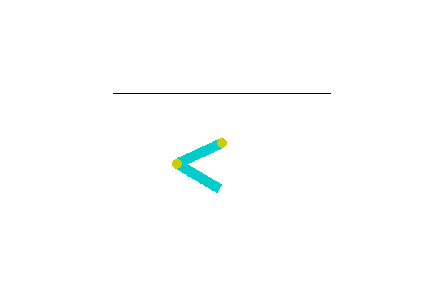
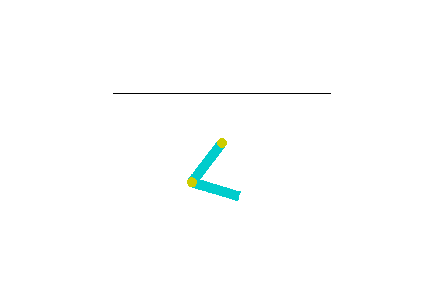
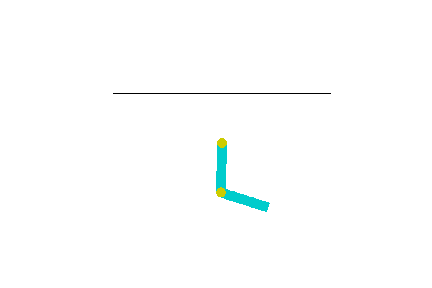
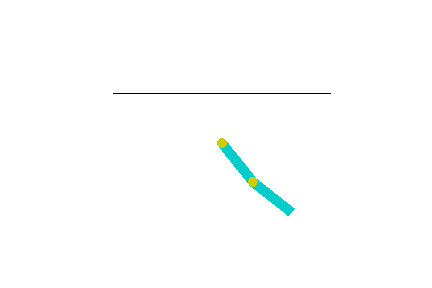
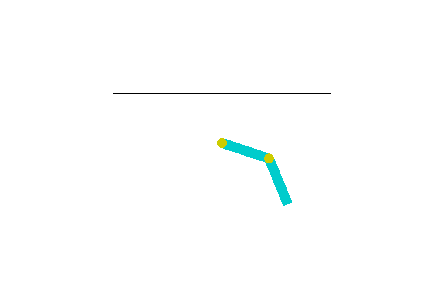
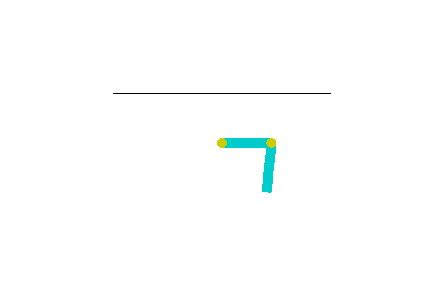
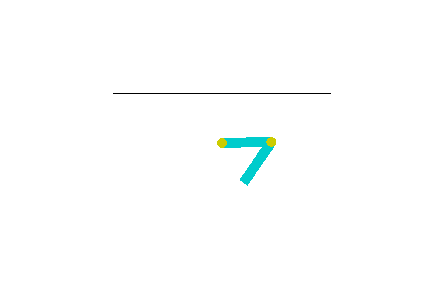
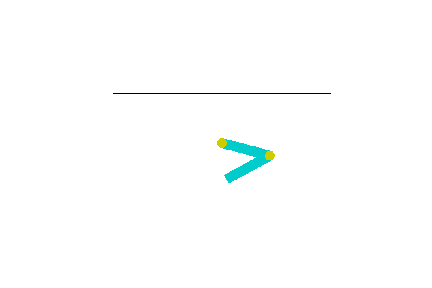
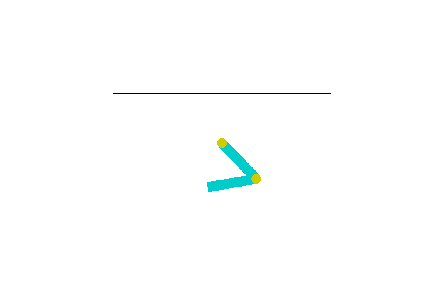
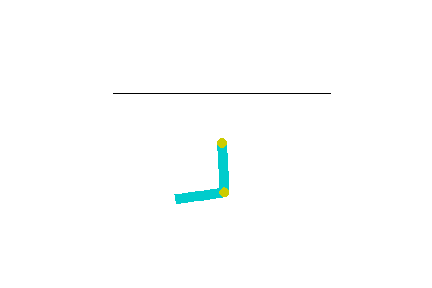
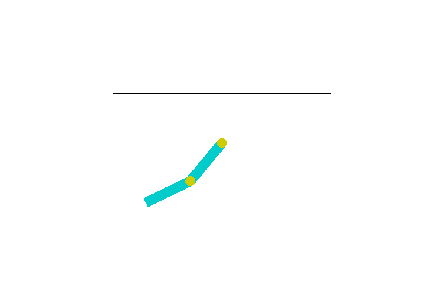
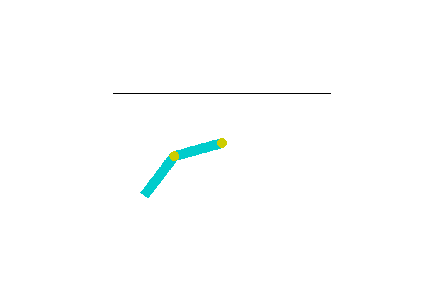
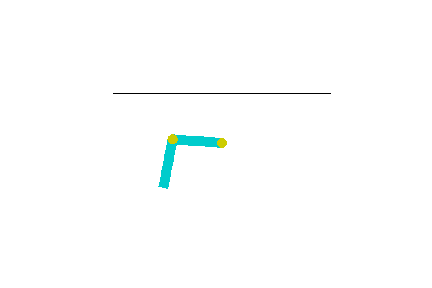
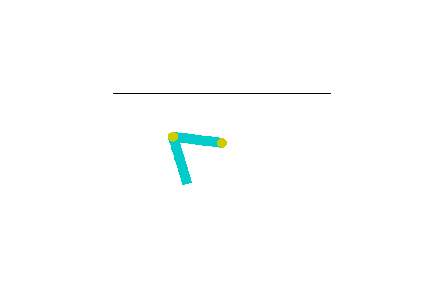
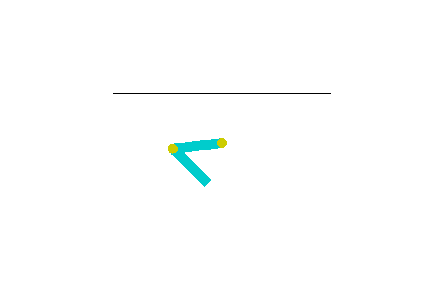
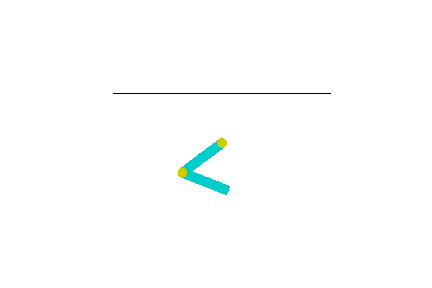
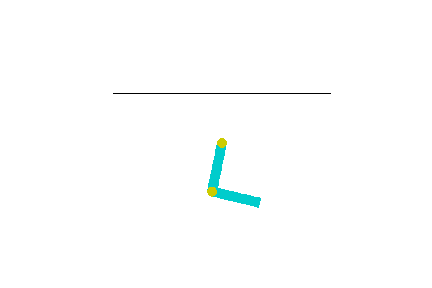
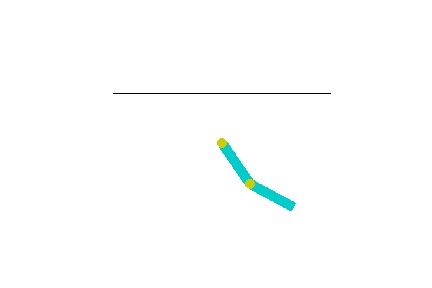
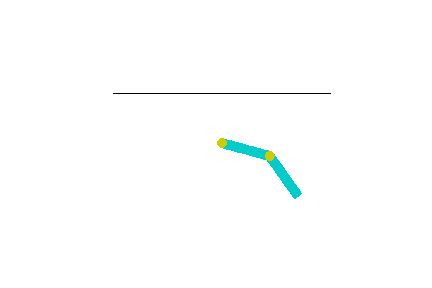
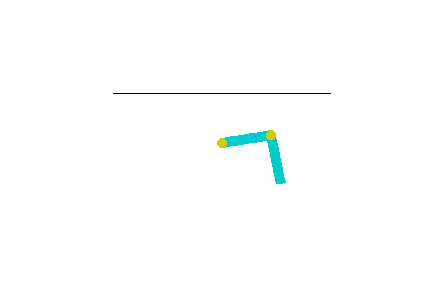
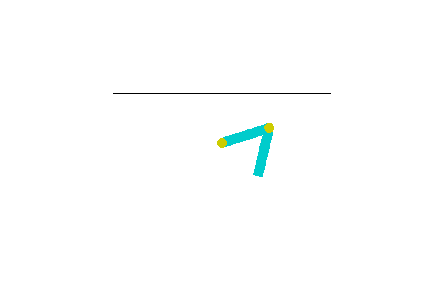
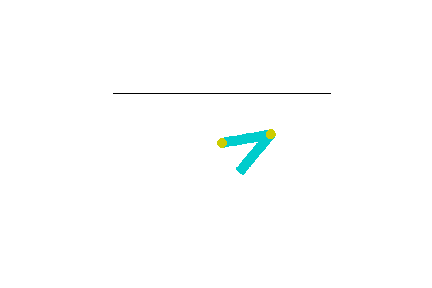
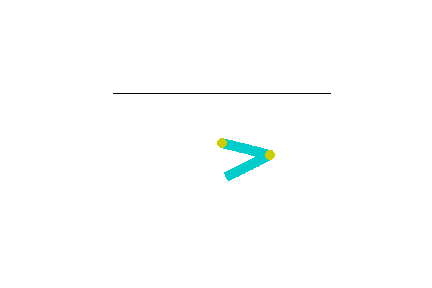
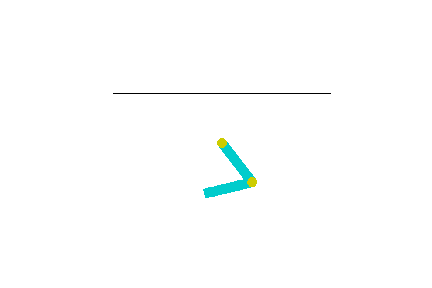
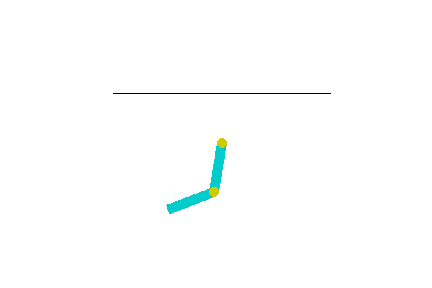
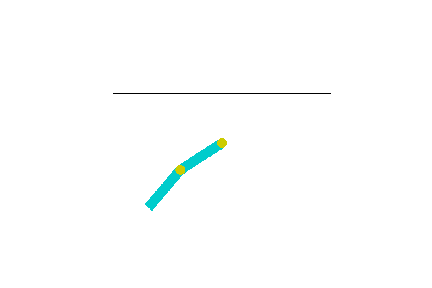
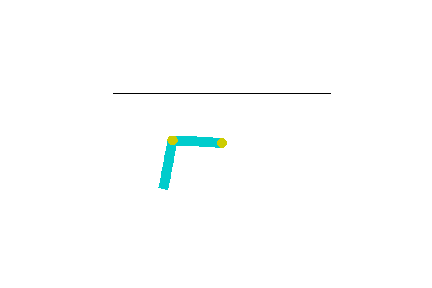
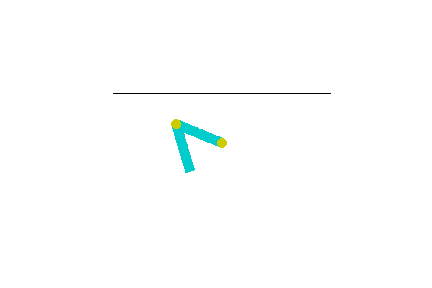
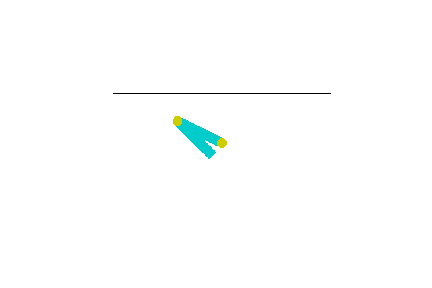
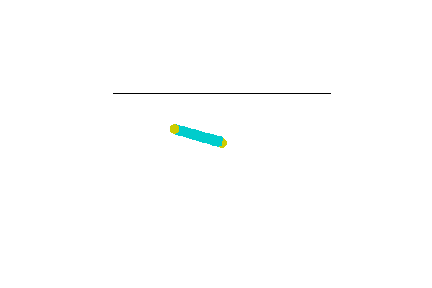
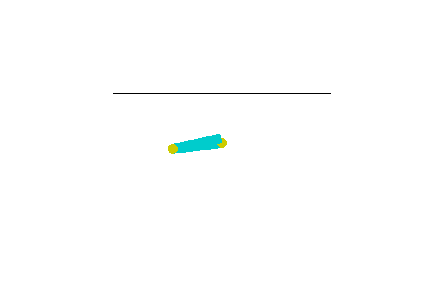
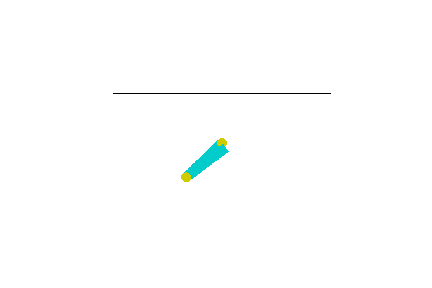
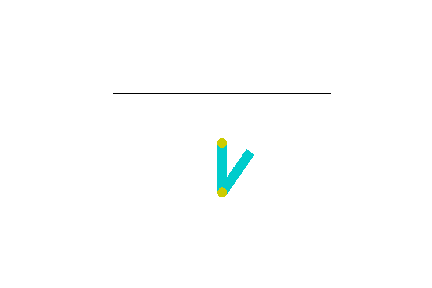
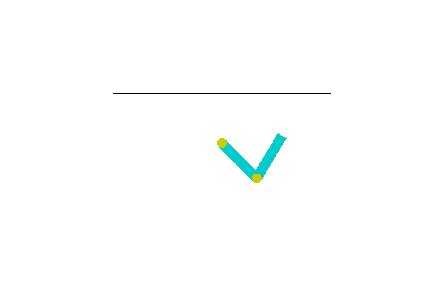
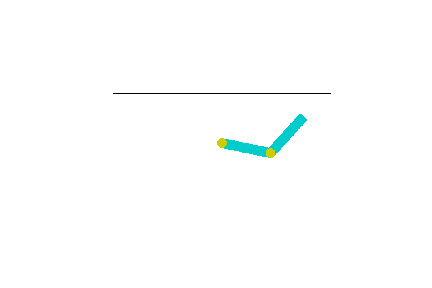
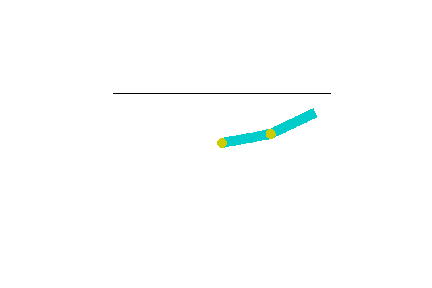
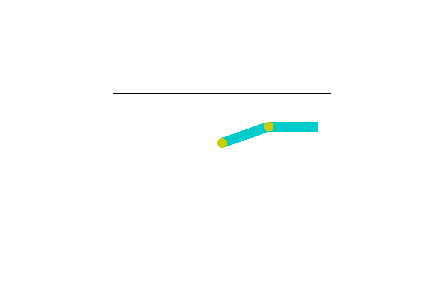
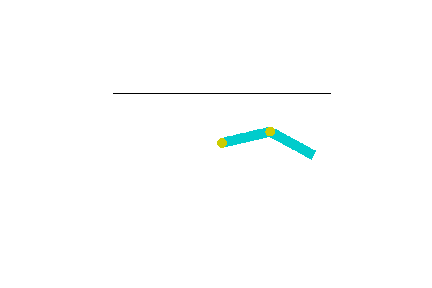
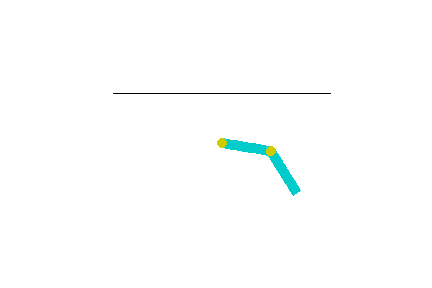
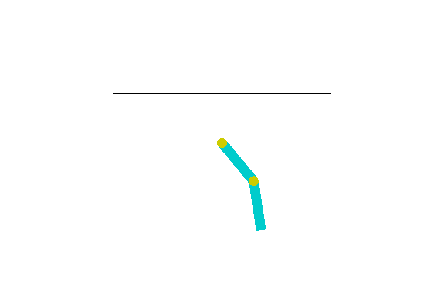
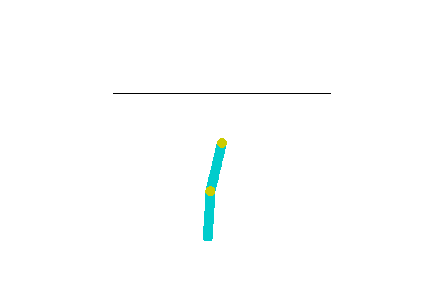
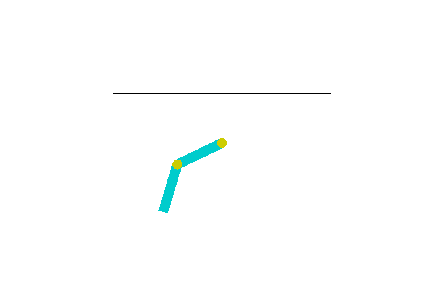
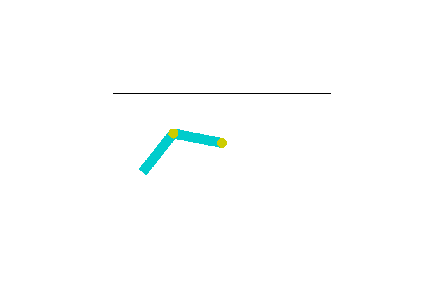
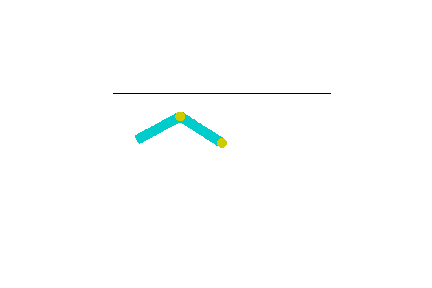
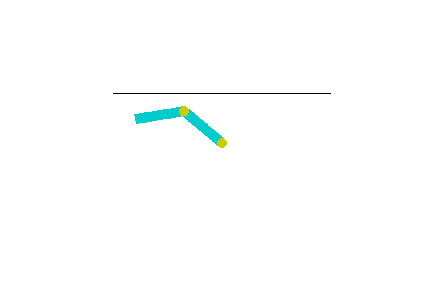
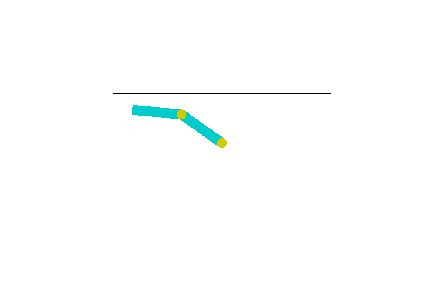
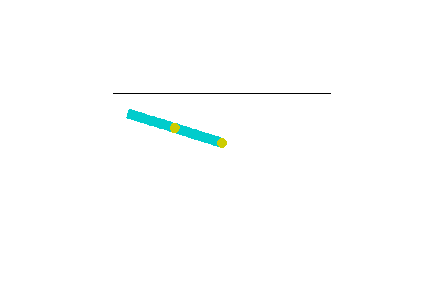
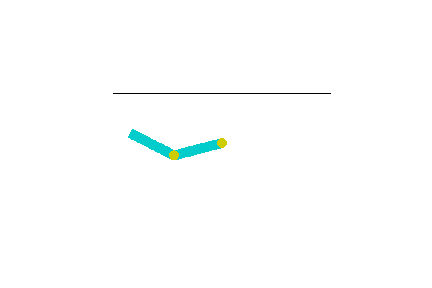
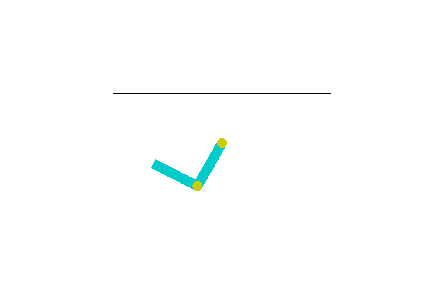
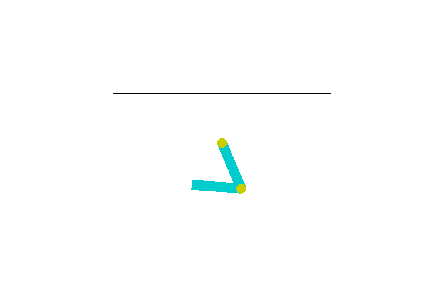
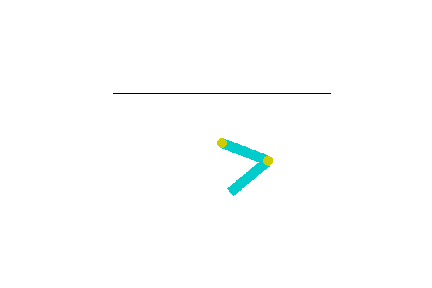
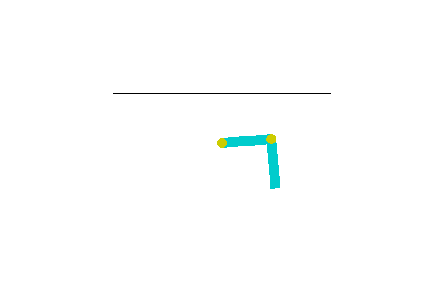
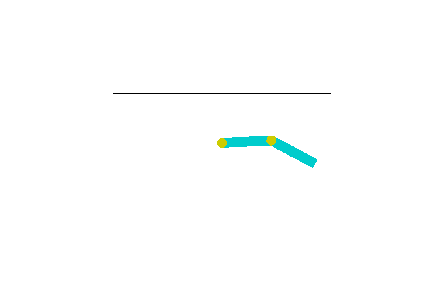
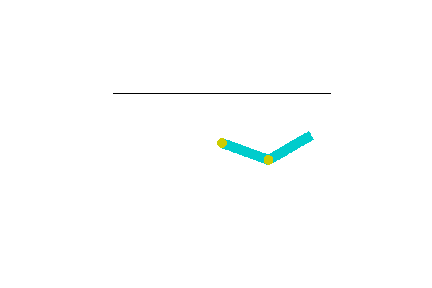
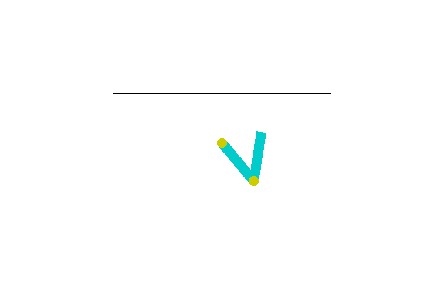
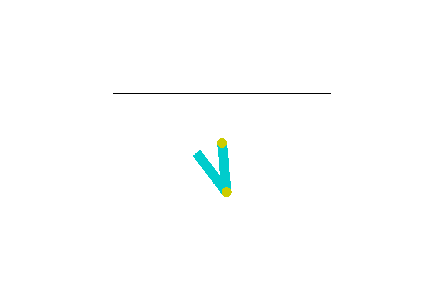
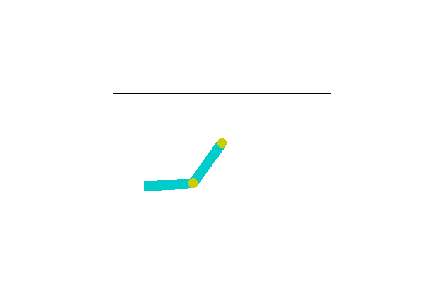
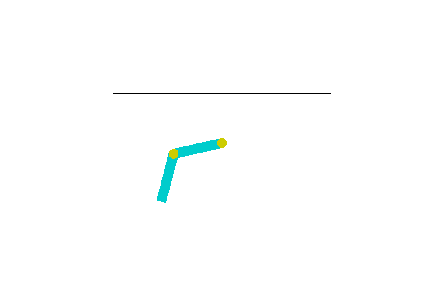
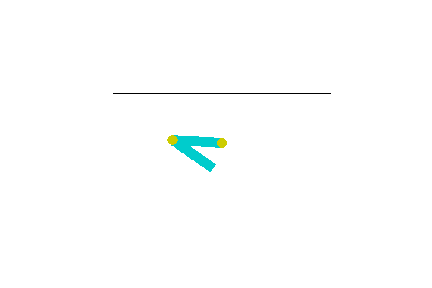
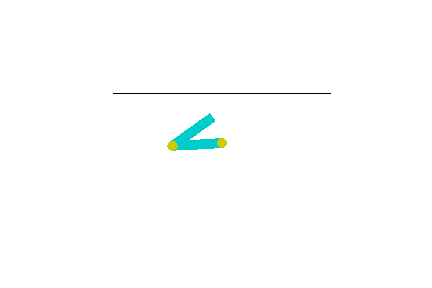
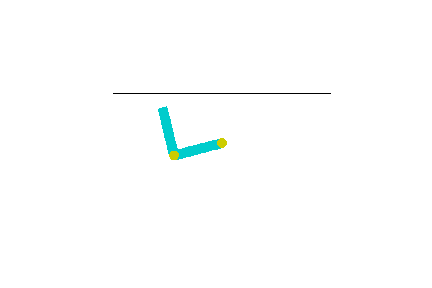
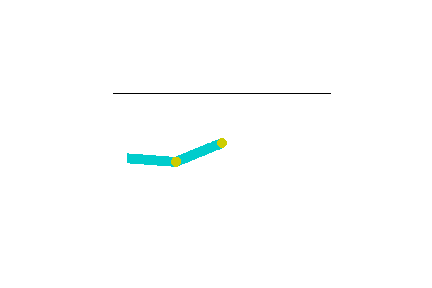
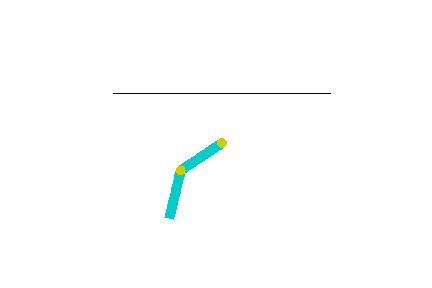
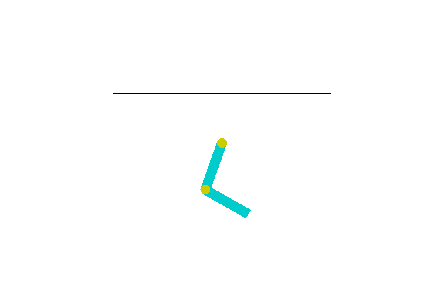
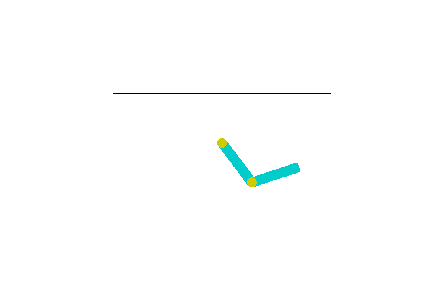
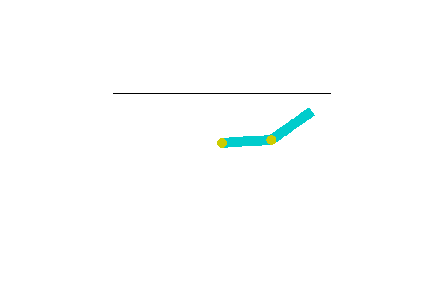

In [20]:
env = gym.make('Acrobot-v1')
obs = env.reset()
total_reward = 0
frames = []
for t in range(env.spec.max_episode_steps):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = epsilon_agent.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)